In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Data has some underlying shape. TDA exploits that idea, with the hope that the noisiness/high-dimensionality/etc. of data may be less of a hassle if we extract the shape and work with that. 
### Often, the pipeline looks a bit like this: data $\rightarrow$ obtain topological representation (like a simplicial complex) $\rightarrow$  compute something from it (like holes) $\rightarrow$ extract parameters of interest. About simplicial complexes, 0D: vertex, 1D: edge, 2D: triangle, 3D: tetrahedron, ... 

## 6.1 RIPS Complex

### One of the most commmonly used simplicial complex is known as the RIPS complex. Let's show pictorially what it means

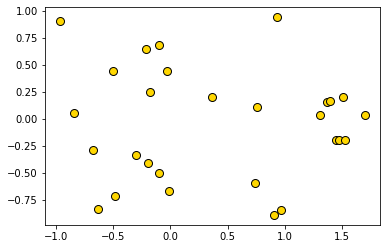

In [7]:
#generate a bunch of points, with some circular datapoints
n = 20
np.random.seed(33)
x = [np.random.uniform(-1,1) for i in range(n)]
y = [np.random.uniform(-1,1) for i in range(n)]
thetalist = [np.random.uniform(0,2*np.pi) for i in range(8)]
x_circ = [1.5+0.2*np.cos(theta) for theta in thetalist]
y_circ = [0.2*np.sin(theta) for theta in thetalist]

x+=x_circ
y+=y_circ

plt.figure()
plt.scatter(x, y, facecolor = 'gold', edgecolor = 'k', s = 64);

### We have our datapoints. TDA is all about shape of data, and the proximity of a datapoint to another is a key topological information. So, naturally, we care about distances between points. Let's start by defining a distance $\epsilon$ that we will call the threshold.

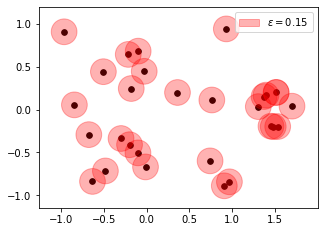

In [8]:
epsilon = 0.15

fig, ax = plt.subplots(figsize = (5,5))
plt.gca().set_aspect('equal', adjustable='box')

ax.scatter(x, y, facecolor = 'k', edgecolor = 'k', s = 32)

for i in range(len(x)):
    circle = plt.Circle((x[i], y[i]), epsilon, color='r', alpha = 0.3)
    ax.add_patch(circle)
circle = plt.Circle((x[i], y[i]), epsilon, color='r', alpha = 0.3, label = r'$\epsilon = 0.15$')
ax.add_patch(circle)
ax.legend();

### For our chosen $\epsilon$, we surround each datapoint by a circle of that radius. Then, it bears to see that some circles will intersect with others (in a nearest-neighbor) fashion, and others won't intersect with any, etc. Varying this threshold from small to large will cause the extent of intersection to increase with time until we can image the whole space to be filled with intersecting circles. Also, notice how our datapoints with circular structure on the right create circles with a hole in between.

### In the next step, we connect each datapoint with another datapoint assuming their circles intersect. Basically, we add points to a local subset assuming the distance between them $d < \epsilon$. 

### As you may imagine, this requires the creation of a pairwise distance matrix. Then, we create a mask that checks for the distance condition.

In [9]:
import sklearn.metrics as metrics

X = np.array([x, y]).T
D = metrics.pairwise_distances(X, Y=None, metric='euclidean')

mask = D<2*epsilon

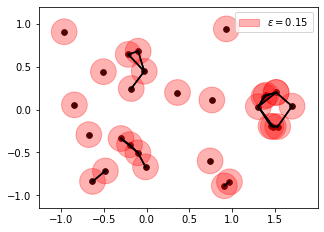

In [72]:
fig, ax = plt.subplots(figsize = (5,5))
plt.gca().set_aspect('equal', adjustable='box')

ax.scatter(x, y, facecolor = 'k', edgecolor = 'k', s = 32)

for i in range(len(x)):
    circle = plt.Circle((x[i], y[i]), epsilon, color='r', alpha = 0.3)
    ax.add_patch(circle)
circle = plt.Circle((x[i], y[i]), epsilon, color='r', alpha = 0.3, label = r'$\epsilon = 0.15$')

for i in range(len(x)):
    for j in range(len(x)):
        val = mask[j][i]
        if val == True:
            ax.plot([x[i], x[j]], [y[i], y[j]], 'k-')
ax.add_patch(circle)
ax.legend();

### This is for $\epsilon = 0.15$. If we increase $\epsilon$, you can imagine that there will be more and more intersection. If two circles intersect, then we have a 1D object (the edge), 2D forms a triangle of points, etc.

### From a simplicial complex like the RIPS complex, we can draw what is known as the persistence diagram, where a topological feature is tracked. Say, we wish to track loops. A loop is formed if there is an unoccupied region in the $x-y$ parameter space bounded by circles. In the plot above, we can see that for $\epsilon = 0.15$ creates a loop for our circular data on the RHS. For a higher $\epsilon$ you can imagine there would be another around the (-0.2, 0.4) coordinates. The idea of a persistence diagram is to increase $\epsilon$ slowly, and to track when such a loop appears (birth) and then to track when it disappears (death). With birth on the x-axis and death on the y-axis, one generates the persistence diagram. By construction the persistence diagram will have datapoints only in the $y>x$ plane. 

### Before creating persistence diagrams, we need to spare a thought to the matrix that was used to create the simplicial complex. In this case, it was a distance matrix between pairs of points. But instead of that one can imagine creating a correlation matrix or 1-correlation matrix. Then say an event happens where all the datapoints drift together; that would mean that they will be more concentrated according to the chosen similarity measure. That will not give much chance for loops to form.  

## 6.2 Analyzing fake data with TDA to understand a simple PH diagram.

#### A circle of radius = 2 units. 

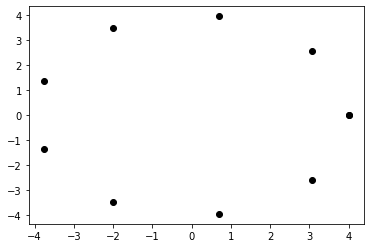

In [126]:
theta = np.linspace(0,2*np.pi,10)
x = [4*np.cos(i) for i in theta]
y = [4*np.sin(i) for i in theta]
plt.plot(x, y, 'ko');

### Use giotto-tda package

In [128]:
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_point_cloud, plot_diagram

In [139]:
VR = VietorisRipsPersistence(metric = "euclidean", homology_dimensions=[0,1]) #create the RIPS complex
X = np.array([x, y]).T
Xt = VR.fit_transform([X])
plot_diagram(Xt[0])

In [140]:
#coordinates of H_1
s = ((x[0]-x[1])**2 + (y[0]-y[1])**2)**.5; print(s)
s = ((x[0]-x[3])**2 + (y[0]-y[3])**2)**.5; print(s)

2.7361611466053497
6.928203230275509


### $H_1$ denotes the creation of loops. Let's look at the green datapoint. The first loop is created when all the points have circles around them and all the circles barely touch. That "birth" happens when $\epsilon = r_1$ where $r_1$ is the distance between nearest neighbors. It turns out that this loop dies when an equilateral triangle is formed in the center (there are 9 datapoints which allows this simple result). This equilateral appears at the scale of the distance between vertex 0 and vertex $n/3$.
### As you can see the coordinates of $H_1$ are indeed calculated above

## 6.3 A more real-life example

### 5 year Apple stock (AAPL) data & Microsoft stock (MSFT): 2013-18
### let's only look at the close data
#### Source: Kaggle

In [10]:
import pandas as pd

In [11]:
aapl = pd.read_csv('./aapl_data.csv')
msft = pd.read_csv('./msft_data.csv')
print(msft.shape, aapl.shape)
print(aapl.head(), "\n", aapl.tail())

(1259, 7) (1259, 7)
        date     open     high      low    close     volume  Name
0   2/8/2013  67.7142  68.4014  66.8928  67.8542  158168416  AAPL
1  2/11/2013  68.0714  69.2771  67.6071  68.5614  129029425  AAPL
2  2/12/2013  68.5014  68.9114  66.8205  66.8428  151829363  AAPL
3  2/13/2013  66.7442  67.6628  66.1742  66.7156  118721995  AAPL
4  2/14/2013  66.3599  67.3771  66.2885  66.6556   88809154  AAPL 
           date     open    high       low   close    volume  Name
1254  2/1/2018  167.165  168.62  166.7600  167.78  47230787  AAPL
1255  2/2/2018  166.000  166.80  160.1000  160.50  86593825  AAPL
1256  2/5/2018  159.100  163.88  156.0000  156.49  72738522  AAPL
1257  2/6/2018  154.830  163.72  154.0000  163.03  68243838  AAPL
1258  2/7/2018  163.085  163.40  159.0685  159.54  51608580  AAPL


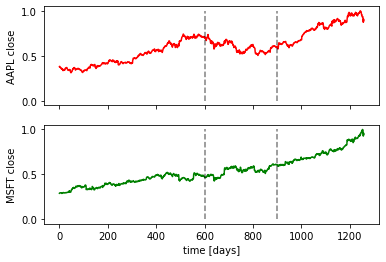

In [146]:
aapl_close = aapl['close']
msft_close = msft['close']

#normalize
aapl_close /= np.max(aapl_close)
msft_close /= np.max(msft_close)

fig, [ax0, ax1] = plt.subplots(2, sharex = True)
ax0.plot(aapl_close, 'r-')
ax1.plot(msft_close, 'g-')

for ax in [ax0, ax1]:
    ax.plot([900, 900], [0., 1.], 'k--', alpha = 0.5)
    ax.plot([600, 600], [0., 1.], 'k--', alpha = 0.5)

ax1.set_xlabel('time [days]')
ax0.set_ylabel('AAPL close')
ax1.set_ylabel('MSFT close');

### The dashed lines show different behavior. Beyond t=900, both increase (positive correlation). There appears to be some negative correlation between t=600-900, up to t=600 some positive correlation

### Let's create a distance matrix between the two

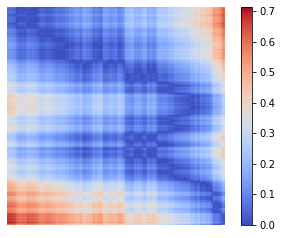

In [147]:
D = metrics.pairwise_distances(X=np.array(aapl_close).reshape(-1, 1), \
                               Y=np.array(msft_close).reshape(-1, 1), metric='euclidean')
fig, ax = plt.subplots()
p = ax.imshow(D, cmap = 'coolwarm')
plt.axis('off')
plt.colorbar(p);

### Notice how the distance matrix has somewhat low values along the diagonals at some times. That shows positive correlation in time. i.e. if on a day AAPL drops, it's likely MSFT drops too. There are many reasons: they may be affected by the same factors (e.g. fiscal changes in law/war/elections, etc.), they're part of the tech industry, etc.

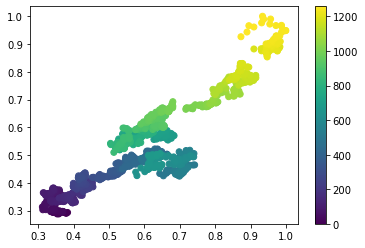

In [148]:
X = np.array([aapl_close, msft_close]).T
p = plt.scatter(X[:,0], X[:,1], c = range(X.shape[0]))
plt.colorbar(p);

In [45]:
plot_point_cloud(X)

In [145]:
VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2]) #create the RIPS complex
Xt = VR.fit_transform([X])
print(Xt.shape)

(1, 11, 3)


In [51]:
plot_diagram(Xt[0])

In [149]:
### Let's look at segments of the data:
#i) positively correlated data
Xt1 = VR.fit_transform([X[900:,:]])
plot_diagram(Xt1[0])

In [150]:
#ii) somewhat negatively correlated data
Xt2 = VR.fit_transform([X[600:900,:]])
plot_diagram(Xt2[0])

### Given two persistence diagrams, the next step of the analysis can take many forms. One of which is the calculation of bottleneck distance (or pairwise distance)

In [168]:
from gtda.diagrams import PairwiseDistance

PD = PairwiseDistance(metric = 'bottleneck', metric_params = {'delta': 0})
X1, X2 = X[900:1200,:], X[600:900,:]
Xt3 = VR.fit_transform([X1, X2])
PD.fit_transform(Xt3)
dist = PD.transform(Xt3)
print(dist[0,1]) #2x2 matrix. The bottleneck distance of a persistence diagram with itself
    #is zero. But the (0,1) and (1,0) elements will give non-zero results

0.017456605944716198


### At this point, the applicability of all of this should be questioned! But this being an introduction to methods, I am stopping short of in-depth analyses. In a real-life situation, one could look at the stock market, say S&P 500, and compare persistence diagrams of the market separated by a window in time. In times of trouble, there appears to be a signature for the bottleneck distance.

## 6.4 Keppler Mapper (kMapper)

### A visualization tool for high dimensional data. It provides a succint representation of complicated data, by showing a graphical representation that exploits the connectivity between datapoints.

In [213]:
import kmapper as km
from sklearn import datasets

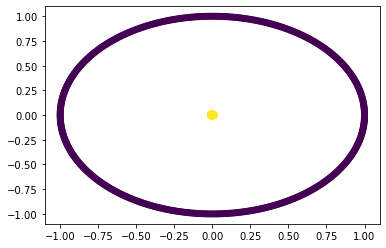

In [243]:
data, labels = datasets.make_circles(n_samples=1000, noise=0.0, factor=0.01)
plt.scatter(data[:, 0], data[:, 1], c = labels);

In [250]:
mapper = km.KeplerMapper(verbose=1)
projected_data = mapper.fit_transform(data, projection=[0,1]) # X-Y axis
graph = mapper.map(projected_data, data, cover=km.Cover(n_cubes=10))
mapper.visualize(graph, path_html="make_circles_keplermapper_output0.html",
                 title="make_circles(n_samples=1000, noise=0.0, factor=0.01)");

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 2) using lens shaped (1000, 2)

Creating 100 hypercubes.

Created 110 edges and 56 nodes in 0:00:00.107831.
Wrote visualization to: make_circles_keplermapper_output0.html


In [245]:
from IPython.display import IFrame
IFrame(src='make_circles_keplermapper_output0.html', width=500, height=400)